# Project 3: 'Image Analysis'
## First Year Project  
### ITU, Spring 2021

This notebook contains all the code developed to explore, wrangle and analyse the raw data sets for our project, 'Image Analysis'.

Contributors:  
- Andy Bao Nguyen (anbn)
- Florian Micliuc (flmi)
- Mattias Wohlert 
- Sofia Elena Terenziani (sote)

Created: 06-04-2021 

Last modified:

### Imports

In [1]:
import cv2
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import matplotlib.cm as cm
import timeit
import missingno as msno
from skimage import morphology
from scipy.spatial.distance import cdist
from scipy.stats.stats import mode
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score
from PIL import Image
from collections import Counter
from skimage.color import rgb2hsv
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

### Functions

Sanity check functions

In [2]:
def check_null_values(file, string):
        if file.isnull().values.any():
            print('There are null values in {} dataset'.format(string))
        else:
            print('There are no null values in {} dataset'.format(string))

In [3]:
def dataset_checker_values(dataset,value):
    SA = dataset.copy()
    SA.replace(value, np.nan, inplace=True)
    missingdata_df = SA.columns[SA.isnull().any()].tolist()
    msno.matrix(SA);

Colour analysis functions

In [4]:
def crop(image):
    y_nonzero, x_nonzero, _ = np.nonzero(image)
    return image[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

In [5]:
def RGB2HEX(color):
     return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

In [6]:
def colour_reader(img,mk):
    im = plt.imread(img)
    #mask is the gray segmentation mask
    mask = plt.imread(mk)
    #putting the color over the mask
    im1 = im.copy()
    im1[mask==0] = 0 #again python dark magic
    #now for better performance we have to crop the image to it's extremities by calling the crop function
    img2 = crop(im1)
    #we have to get the coordinates of every pixel in the image so
    xy_coords = np.flip(np.column_stack(np.where(img2 >= 0)), axis=1)
    #if we print xy_coords they will appear three times because every pixel has three colour coordinates, namely RGB,thus
    #I have to delete the first column(which is 0,1,2) and the duplicates
    a_del = np.delete(xy_coords, 0, 1)
    a_del = a_del[::3][:, [0, 1]] #python dark magic
    #now we get all the rgb colours from every pixel in our picture
    image = Image.fromarray(img2)
    rgb_image = image.convert('RGB')
    rgb1 = [rgb_image.getpixel((int(i[0]),int(i[1]))) for i in a_del]
    #now to reduce it as much as we can we turn it to hexcodes so we don't have tuples of 3 values and we eliminate duplicates
    dd = [RGB2HEX(i) for i in rgb1]
    ss = list(set(dd)) #ye,I know
    #now just a nice thing, to count how many colours appear in our picture, first one is useless since it will always be black
    counter_colours =  Counter(dd)
    #popping the black color
    counter_colours.pop('#000000')
    return counter_colours

In [7]:
def hsv(img,seg):
    im = plt.imread(img)
    mask = plt.imread(seg)
    im1 = im.copy()
    im1[mask==0] = 0
    new_arr_no_0 = im1[np.where(im1!=0)]
    img2 = crop(im1)
    image_copy = img2.copy()
    non_black_pixels_mask = np.any(img2 != [0, 0, 0], axis=-1)  
    no_black = image_copy[non_black_pixels_mask]
    hsv_image = rgb2hsv(no_black)
    min_max = [np.amax(hsv_image[:,1]) - np.amin(hsv_image[:,1])]
    return min_max

Asymmetry functions

In [8]:
def asymmetry_level(im): 
    #Read image
    im = plt.imread(im)
    
    #Crop the picture
    #Center of the shape is the center of the image
    #The borders of the shape are the borders of the image
    y_nonzero, x_nonzero = np.nonzero(im)
    im = im[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]
    
    #Cut the image in halves 
    #Find the point of cutoff
    height, width = im.shape
    width_cutoff = width // 2
    height_cutoff = height // 2
    
    #Cut the image vertically and horizontally in two 
    imVertical1 = im[:, :width_cutoff]
    imVertical2 = im[:, width_cutoff:]
    imHorizontal1 = im[:height_cutoff, :]
    imHorizontal2 = im[height_cutoff:, :]
    
    #Flip image 
    #Interting one of the images both vertically and horizontally   
    indexerVertical = [slice(None)] * imVertical2.ndim
    indexerHorizontal = [slice(None)] * imHorizontal2.ndim
    indexerVertical[1] = slice(None, None, -1)
    indexerHorizontal[0] = slice(None, None, -1) 
    imVertical2 = imVertical2[tuple(indexerVertical)]
    imHorizontal2 = imHorizontal2[tuple(indexerHorizontal)]

    #Cut the biggest image, if the images don't have the same shape 
    #This can happen if the shape of the original shape was an odd number 
    imVertical2 = imVertical2[0:imVertical1.shape[0], 0:imVertical1.shape[1]]
    imHorizontal2 = imHorizontal2[0:imHorizontal1.shape[0], 0:imHorizontal1.shape[1]]

    img_bwxVertical = cv2.bitwise_xor(imVertical1,imVertical2)
    img_bwxHorizontal = cv2.bitwise_xor(imHorizontal1,imHorizontal2)
    
    areaVertical = np.sum(img_bwxVertical == 1)
    areaHorizontal = np.sum(img_bwxHorizontal == 1)
    areaMean = (areaVertical + areaHorizontal) // 2
    
    #The asymmetry level (AS) is calculated as a percentage of the non-zero pixels in the overlapped image over the lesion area 
    return (areaMean / np.sum(im == 1)) *100

Prediction functions

In [9]:
def make_knn_prediction(k,train,classes,test):
    neigh = KNeighborsClassifier(n_neighbors = k)
    neigh.fit(train,classes.ravel())
    clas_pred = neigh.predict(test)
    return clas_pred

In [10]:
def accuracy_test(k,train,classes,test,classes_test):
    performance = []
    perform1 =[]
    for i in range(1,k):
        a = make_knn_prediction(i,train,classes,test)
        performance.append(a)
        for j in performance:
            b = accuracy_score(classes_test,j)
        perform1.append(b)
    fig, axes = plt.subplots()
    axes.plot(perform1)
    plt.title("Classification Accuracy of KNN for Different Values of k")
    plt.ylabel("Test Accuracy")
    plt.xlabel("Value of k");
    plt.grid(color='grey', linestyle='--', linewidth=0.5)
    return np.mean(perform1)

### Loading the data

Data loading description pending

In [74]:
image_folder = '../data/raw/example_image/'
segmentation_folder = '../data/raw/example_segmentation/'

extra_image_folder = '../data/raw/extra_keratosis'
extra_segmentation_folder = '../data/raw/extra_segmentation'


extra_ground_truth = '../data/raw/ISIC-2017_Training_Part3_GroundTruth.csv'
ground_truth = '../data/raw/example_ground_truth.csv'
features = '../data/features/features.csv'

In [75]:
image_files = os.listdir(image_folder)
segmentation_files = os.listdir(segmentation_folder)

extra_image_files = os.listdir(extra_image_folder)
extra_segmentation_files = os.listdir(extra_segmentation_folder)

extra_gt = pd.read_csv(extra_ground_truth)
ground_truth = pd.read_csv(ground_truth)
features = pd.read_csv(features)

## Task 0 - Data checking and filtering

### CSV files sanity checks

In [76]:
check_null_values(ground_truth,'ground_truth')
check_null_values(features,'features')
check_null_values(extra_gt,'extra_ground_truth')

There are no null values in ground_truth dataset
There are no null values in features dataset
There are no null values in extra_ground_truth dataset


In [77]:
#dataset_checker_values(ground_truth,-1)
#dataset_checker_values(features,-1)
#dataset_checker_values(extra_gt,-1)

There are no gaps in the plots, thus the value -1 (missing data) does not occur in the dataset

In [78]:
if True in list(ground_truth.duplicated()):
    print("Duplicate rows")
else: 
    print("No duplicate rows")

No duplicate rows


In [79]:
if True in list(features.duplicated()):
    print("Duplicate rows")
else:
    print("No duplicate rows")

No duplicate rows


In [80]:
if True in list(extra_gt.duplicated()):
    print('Duplicate rows')
else:
    print('No duplicate rows')

No duplicate rows


### Data Manipulation

In [81]:
ground_truth = ground_truth.set_index('image_id')
features = features.set_index('id')
extra_gt = extra_gt.set_index('image_id')

In [82]:
color_images_paths = []
segmentation = []

# getting the image_paths
for i in image_files[1:]:
    image_path= os.path.join(image_folder,i)
    if not i.endswith('superpixels.png'):
        color_images_paths.append(image_path)
for i in segmentation_files:
    image_path1 = os.path.join(segmentation_folder,i)
    segmentation.append(image_path1)

# would be nice to create a function that actually checks if the tuple contains the right colored image and segemntation one
both_images = list(zip(color_images_paths,segmentation))

#splitting the images
keratosis_images = ground_truth.index[ground_truth['seborrheic_keratosis'] == 1.0].tolist()
melanoma_images = ground_truth.index[ground_truth['melanoma'] == 1.0].tolist()
healthy_images = ground_truth[(ground_truth['seborrheic_keratosis'] == 0.0) & (ground_truth['melanoma'] == 0.0)]
#print(healthy_images.index.tolist) - to get only the healthy images in a list hence the healthy_images is a df

keratosis = [os.path.join(image_folder,i + '.jpg') for i in keratosis_images] #positive keratosis colour_images path
melanoma = [os.path.join(image_folder,i + '.jpg') for i in melanoma_images] #positive melanoma colour_images path
healthy = [os.path.join(image_folder,i + '.jpg') for i in healthy_images.index.tolist()] #healthy colour_images path

k_segmentation = [os.path.join(segmentation_folder,i + '_segmentation.png') for i in keratosis_images] #positive keratosis segmentation path
m_segmentation = [os.path.join(segmentation_folder,i + '_segmentation.png') for i in melanoma_images] #positive melanoma segmentation path
h_segmentation = [os.path.join(segmentation_folder,i + '_segmentation.png') for i in healthy_images.index.tolist()]#healthy segmentation path"

In [83]:
final_keratosis = list(zip(keratosis,k_segmentation))
final_melanoma = list(zip(melanoma,m_segmentation))
final_healthy = list(zip(healthy,h_segmentation))

### Extra Data - provided from ISIC 2017 challenge

In [84]:
extra_keratosis = [os.path.join(extra_image_folder,i) for i in extra_image_files]
extra_segmentation = [os.path.join(extra_segmentation_folder,i) for i in extra_segmentation_files ]
final_extra = list(zip(extra_keratosis,extra_segmentation))

In [95]:
Keratosis_all = final_keratosis + final_extra

In [94]:
segm_k_all = k_segmentation + extra_segmentation

## Task 1 - Feature analysis

### 1.1 Colour Analysis - Step by step example of the colour_reader function

Reading the coloured and the segmentation files

In [26]:
im = plt.imread(keratosis[1])
mask = plt.imread(k_segmentation[1])

Basic knowledge about the lession such as area and perimeter (not absolutely necessary for colour analysis)

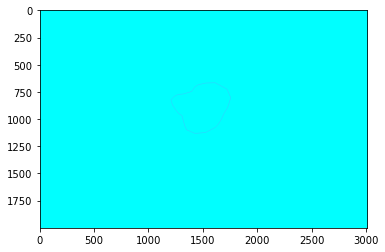

In [27]:
area = np.sum(mask)
struct_el = morphology.disk(1)
mask_eroded = morphology.binary_erosion(mask, struct_el)
image_perimeter = mask - mask_eroded
perimeter = np.sum(image_perimeter)
plt.imshow(image_perimeter,cmap = 'cool') # really small but visible with cool cmap
#print(' The area is -> ',area,'\\n','The perimeter is -> ',perimeter)

Taking the lession and displaying it over the segmentation

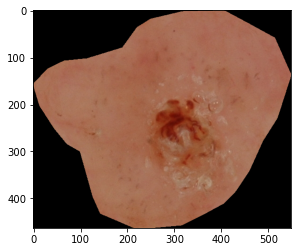

In [28]:
im1 = im.copy()
im1[mask==0] = 0
new_arr_no_0 = im1[np.where(im1!=0)]
#cropping the image for better performance
im1 = crop(im1)
plt.imshow(im1) #not best crop but manageable

Getting every pixel's coordinates

In [29]:
xy_coords = np.flip(np.column_stack(np.where(im1 >= 0)), axis=1)
a_del = np.delete(xy_coords, 0, 1)
a_del = a_del[::3][:, [0, 1]] #python dark magic and true coordinates

Getting every pixel's RGB values and converting them to HEX codes

In [30]:
image = Image.fromarray(im1)
rgb_image = image.convert('RGB')
rgb1 = [rgb_image.getpixel((int(i[0]),int(i[1]))) for i in a_del]
hex_codes = [RGB2HEX(i) for i in rgb1]
counted_colours = Counter(hex_codes)
counted_colours.pop('#000000')
print(len(rgb1)) #3,379,770 

253724


In [31]:
#print(counted_colours)

The conversion of the RGB values to hex codes is due to the fact RGB values come in tuples of three (R,G,B), therefore, for a better performance we turn them to HEX codes ( which are basically #RGB values ) and then we count their appearance

In [32]:
final_k = [colour_reader(i[0],i[1]) for i in final_keratosis[:20]]
final_h = [colour_reader(i[0],i[1]) for i in final_healthy[:20]]

In [33]:
k_len = [len(i) for i in final_k]
h_len = [len(i) for i in final_h]

Due to some decisions, we decided to count the number of colours,thus giving us the color variation, and then feed them to the prediction algorithm

### 1.2 Colour Analysis - Step by step example explaining the hsv function

In [34]:
image_copy = im1.copy()
non_black_pixels_mask = np.any(im1 != [0, 0, 0], axis=-1)  

Copying the first image and then creating a mask without the black borders

In [35]:
hsv_pic = rgb2hsv(image_copy[non_black_pixels_mask])
maximum = np.max(hsv_pic[:,1])
minimum = np.min(hsv_pic[:,1])

Converting the image from RGB values to HSV values to get the saturation and getting the difference between brightest and darkest spot

### 1.3 Symmetry analysis - Step by step example for asymmetry level function

In [36]:
im_sym = plt.imread(k_segmentation[1])
y_nonzero, x_nonzero = np.nonzero(im_sym)
im_sym = im_sym[np.min(y_nonzero):np.max(y_nonzero), np.min(x_nonzero):np.max(x_nonzero)]

Crop the picture  
Center of the shape is the center of the image  
The borders of the shape are the borders of the image

In [37]:
height, width = im_sym.shape
width_cutoff = width // 2
height_cutoff = height // 2

Cut the image in halves   
Find the point of cutoff

In [38]:
imVertical1 = im_sym[:, :width_cutoff]
imVertical2 = im_sym[:, width_cutoff:]
imHorizontal1 = im_sym[:height_cutoff, :]
imHorizontal2 = im_sym[height_cutoff:, :]

Cut the image vertically and horizontally in two 

In [39]:
indexerVertical = [slice(None)] * imVertical2.ndim
indexerHorizontal = [slice(None)] * imHorizontal2.ndim
indexerVertical[1] = slice(None, None, -1)
indexerHorizontal[0] = slice(None, None, -1) 
imVertical2 = imVertical2[tuple(indexerVertical)]
imHorizontal2 = imHorizontal2[tuple(indexerHorizontal)]

Flip image  
Interting one of the images both vertically and horizontally  

In [40]:
imVertical2 = imVertical2[0:imVertical1.shape[0], 0:imVertical1.shape[1]]
imHorizontal2 = imHorizontal2[0:imHorizontal1.shape[0], 0:imHorizontal1.shape[1]]

Cut the biggest image, if the images don't have the same shape   
This can happen if the shape of the original shape was an odd number 

In [41]:
img_bwxVertical = cv2.bitwise_xor(imVertical1,imVertical2)
img_bwxHorizontal = cv2.bitwise_xor(imHorizontal1,imHorizontal2)

In [42]:
areaVertical = np.sum(img_bwxVertical == 1)
areaHorizontal = np.sum(img_bwxHorizontal == 1)
areaMean = (areaVertical + areaHorizontal) // 2

In [43]:
print(areaMean / np.sum(im_sym == 1) *100)

15.263028916843652


The asymmetry level (AS) is calculated as a percentage of the non-zero pixels in the overlapped image over the lesion area 

In [96]:
k_sym = [asymmetry_level(i) for i in segm_k_all]
h_sym = [asymmetry_level(i) for i in h_segmentation]

## Task 2 - Diagnosis prediction

In [101]:
#UPDATED
clas_k = np.array([1 for i in range(len(Keratosis_all))])
clas_h = np.array([0 for i in range(len(healthy))])
clas = np.array([y for x in [clas_k, clas_h] for y in x])

### 2.1 - Color variation

In [ ]:
feed = np.array(k_len + h_len)

In [ ]:
feed_train,feed_test,clas_train,clas_test = train_test_split(feed,clas,test_size = 0.6,random_state = 4)

In [ ]:
feed_train= feed_train.reshape(-1, 1)
clas_train= clas_train.reshape(-1, 1)
feed_test = feed_test.reshape(-1, 1)

In [ ]:
print(make_knn_prediction(7,feed_train,clas_train,feed_test))
print(clas_test)

In [ ]:
#do a function out of this #DONE
performance = []
perform1 =[]
for i in range(1,10):
    a = make_knn_prediction(i,feed_train,clas_train,feed_test)
    performance.append(a)
    for j in performance:
        b = accuracy_score(clas_test,j)
    perform1.append(b)
fig, axes = plt.subplots()
axes.plot(perform1)
#axes.set_ylim([0.85,1])
plt.title("Iris Classification Accuracy of KNN for Different Values of k")
plt.ylabel("Test Accuracy")
plt.xlabel("Value of k");
plt.grid(color='grey', linestyle='--', linewidth=0.5)
print(np.mean(perform1))

### 2.2 Saturation

In [110]:
k_hsv = [hsv(i[0],i[1]) for i in Keratosis_all]
h_hsv = [hsv(i[0],i[1]) for i in final_healthy]

In [111]:
feed2 = np.array([y for x in [k_hsv, h_hsv] for y in x])

In [112]:
feed2_train,feed2_test,clas_train,clas_test = train_test_split(feed2,clas,test_size = 0.6,random_state = 4)

In [113]:
feed2_train= feed2_train.reshape(-1, 1)
clas_train= clas_train.reshape(-1, 1)
feed2_test = feed2_test.reshape(-1, 1)

In [114]:
print(make_knn_prediction(6,feed2_train,clas_train,feed2_test))
print(clas_test)

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 0 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0
 0 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
[0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1
 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 0 0 0 0 1]


0.7452651515151516

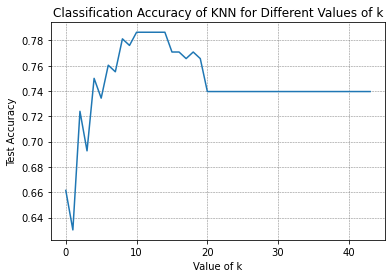

In [115]:
accuracy_test(45,feed2_train,clas_train,feed2_test,clas_test)

### 2.3 Asymmetry

In [102]:
feed3 = np.array([y for x in [k_sym, h_sym] for y in x])

In [103]:
feed3_train,feed3_test,clas_train,clas_test = train_test_split(feed3,clas,test_size = 0.6,random_state = 4)

In [104]:
feed3_train= feed3_train.reshape(-1, 1)
clas_train= clas_train.reshape(-1, 1)
feed3_test = feed3_test.reshape(-1, 1)

In [105]:
print(make_knn_prediction(7,feed3_train,clas_train,feed3_test))
print(clas_test)

[1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 1]
[0 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 0 0 1 0 1 1 1 1
 1 1 1 0 1 1 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 0 1 1 0 1 1 1
 1 0 1 0 0 1 1 0 0 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1
 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 0 1 0 0 0 0 1]


0.7345500700280109

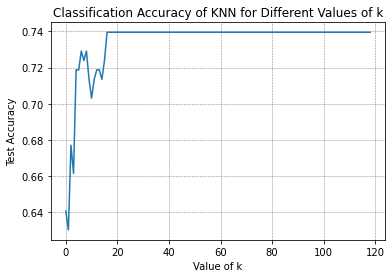

In [109]:
accuracy_test(120,feed3_train,clas_train,feed3_test,clas_test)

## Task 3 - Open question

# WORK IN PROGRESS

In [ ]:
#Example_ground_truth
#Features
ex_ground = pd.read_csv("../data/raw/example_ground_truth.csv")
features = pd.read_csv("../data/features/features.csv")
images = ("../data/raw/example_image/")
segmentations = ("../data/raw/example_segmentation/")

In [ ]:
# Create a DataFrame object
df_exground = pd.DataFrame(ex_ground, columns =['image_id', 'melanoma', 'seborrheic_keratosis'])

# Iterate over the index range from
# 0 to max number of columns in dataframe
for i in range(df_exground.shape[1]):

    print('Column Number : ', i)

    # Select column by index position using iloc[]
    columnSeriesObj = df_exground.iloc[:, i]
    print('Column Contents : ', columnSeriesObj.values)

In [ ]:
features

# Loading of data and scripts

In [ ]:
%run ../Scripts/fyp2021p3_group00_functions.py

In [ ]:
im = plt.imread("../Data/Raw/example_image/ISIC_0014310.jpg")
print(im.shape)
plt.imshow(im)
plt.imshow(im[:,:,0], cmap='gray')

In [ ]:
def rgb2gray(rgb):
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    gray = 0.2989 * r * 0.5870 * g + 0.1140 * b
    return gray

grey = rgb2gray(im)
plt.imshow(grey,  cmap = "gray")

# Lesion is darker, and extract a mask of it

In [ ]:
plt.hist(grey)
# Will run for a minute or two

In [ ]:
# Our lesion is in the smaller clusters (The darker pixels), and the greater ones must be the pixels of the skin
im_lim = grey < 4500
plt.imshow(im_lim, cmap = "gray") # We see a little noice within our lesion

## Holy shit some messed op edge detections
The resized image testing here is somewhat crazy if you run it, you will get the image in gray, and an edge detection via Laplacian method.

In [ ]:
test_image = cv2.imread("../Data/Raw/example_image/ISIC_0015445.jpg", cv2.IMREAD_GRAYSCALE)
test_image1 = cv2.imread("../Data/Raw/example_image/ISIC_0012876.jpg", cv2.IMREAD_GRAYSCALE)

#ISIC_0012876.jpg: 130332409512 variance value with blur filter
#ISIC_0012547.jpg: 328304917890 variance value with blur filter
#ISIC_0014616.jpg: 254861476159 variance value with blur filter
#ISIC_0015445.jpg: 65980525961 original variance value, 84519790131 variance value with blur filter

#above images are sharp ass hell and with clear example of their blurry version
#Images that are less than 2 billion in variance, is considered non-blurry for the above .jpg examples



image_unblur = cv2.resize(test_image, (960, 540))
imageS = cv2.resize(test_image, (460, 280))
imageS1 = cv2.resize(test_image1, (460, 280))

#blur_sharpening = cv2.GaussianBlur(imageS, (0, 0), 3); #This line makes the images very blurry
#cv::addWeighted(frame, 1.5, image, -0.5, 0, image);


imageB = cv2.GaussianBlur(imageS, (5,5), 0) #Biased images are blurry
#imageS = cv2.blur(imageS, (5,5))
laplacian_image = cv2.Laplacian(imageS, cv2.CV_64F, ksize=11)#Change the ksize to get different edge detections, only odd numbers works
laplacian_image1 = cv2.Laplacian(imageS1, cv2.CV_64F, ksize=11)
canny = cv2.Canny(imageS, 20, 21) #You can change the numbers of values, to where it sees something as an edge

#Laplacian.var() works in such a way that it checks for defined edges, and if the image is blurry there wound be such a clear edge like line
img_variance = cv2.Laplacian(image_unblur, cv2.CV_64F, ksize=11).var()
img_blur = cv2.Laplacian(imageB, cv2.CV_64F, ksize=11).var()

if img_variance < 80000000000:
    print(img_variance, "variance value is less than 80.000.000.000 milliard, the image is blurry")
else:
    print(img_variance, "variance value is above 80.000.000.000 milliard, image is not blurry")

print(img_blur, "variance value of an image with gaussian blur filter on")

#cv2.imshow("Blur to sharp", blur_sharpening)
#cv2.imshow("Original image no blur", image_unblur)
cv2.imshow("Blur filter", imageB)
cv2.imshow("Laplacian", laplacian_image)
cv2.imshow("Laplacian1", laplacian_image1)
#cv2.imshow("Canny", canny) #The Canny edge detection is kinda weird

cv2.waitKey(0)
cv2.destroyAllWindows()

# Folder images multiple ways

In [ ]:
# This will get all the files in a folder in onlyfiles. And then it will read them all and store them in the array images.
onlyfiles = [f for f in os.listdir(images) if os.path.isfile(os.path.join(images, f))]
image_s = np.empty(len(onlyfiles), dtype = object)
for n in range(0, len(onlyfiles)):
    image_s[n] = cv2.imread(os.path.join(images, onlyfiles[n]))

In [ ]:
for i in image_s:
    print(i)

In [ ]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [ ]:
load_images_from_folder(images)